<a href="https://colab.research.google.com/github/ElenaGordienko1/ML/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [87]:
!pip install pandas scikit-learn seaborn scipy

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [89]:
# Загрузка набора данных
df = pd.read_csv('/content/heart_disease.csv')

In [90]:
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0


In [91]:
df['old_and_sick'] = np.where(df['age'] >= 50, 1, 0)
df.old_and_sick = df.old_and_sick.astype('category')
df['sex'] = df['sex'].astype('category')

In [92]:
Y = df['old_and_sick'] # выбираем целевую переменную (категориальную)
X = df.drop('old_and_sick', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)

In [93]:
df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   sex                                   270 non-null    category
 1   chest pain type                       270 non-null    int64   
 2   resting blood pressure                270 non-null    int64   
 3   serum cholestoral in mg/dl            270 non-null    int64   
 4   fasting blood sugar > 120 mg/dl       270 non-null    int64   
 5   resting electrocardiographic results  270 non-null    int64   
 6   maximum heart rate achieved           270 non-null    int64   
 7   exercise induced angina               270 non-null    int64   
 8   oldpeak                               270 non-null    float64 
 9   slope of peak                         270 non-null    int64   
 10  number of major vessels               270 non-null    int64   
 11  thal  

In [94]:
df

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,old_and_sick
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0,1
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0,1
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0,1


## 2: масштабирование признаков

In [95]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   sex                                   270 non-null    category
 1   chest pain type                       270 non-null    int64   
 2   resting blood pressure                270 non-null    int64   
 3   serum cholestoral in mg/dl            270 non-null    int64   
 4   fasting blood sugar > 120 mg/dl       270 non-null    int64   
 5   resting electrocardiographic results  270 non-null    int64   
 6   maximum heart rate achieved           270 non-null    int64   
 7   exercise induced angina               270 non-null    int64   
 8   oldpeak                               270 non-null    float64 
 9   slope of peak                         270 non-null    int64   
 10  number of major vessels               270 non-null    int64   
 11  thal  

In [96]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [97]:
X_processed

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,sex_1
0,4,130,322,0,2,109,0,2.4,2,3,3,1,True
1,3,115,564,0,2,160,0,1.6,2,0,7,0,False
2,2,124,261,0,0,141,0,0.3,1,0,7,1,True
3,4,128,263,0,0,105,1,0.2,2,1,7,0,True
4,2,120,269,0,2,121,1,0.2,1,1,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3,172,199,1,0,162,0,0.5,1,0,7,0,True
266,2,120,263,0,0,173,0,0.0,1,0,7,0,True
267,2,140,294,0,2,153,0,1.3,2,0,3,0,False
268,4,140,192,0,0,148,0,0.4,2,0,6,0,True


In [98]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [99]:
X_processed

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,sex_1
0,4,130,322,0,2,109,0,0.387097,2,3,3,1,True
1,3,115,564,0,2,160,0,0.258065,2,0,7,0,False
2,2,124,261,0,0,141,0,0.048387,1,0,7,1,True
3,4,128,263,0,0,105,1,0.032258,2,1,7,0,True
4,2,120,269,0,2,121,1,0.032258,1,1,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3,172,199,1,0,162,0,0.080645,1,0,7,0,True
266,2,120,263,0,0,173,0,0.000000,1,0,7,0,True
267,2,140,294,0,2,153,0,0.209677,2,0,3,0,False
268,4,140,192,0,0,148,0,0.064516,2,0,6,0,True


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [100]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [101]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.7963
Точность на тестовой выборке: 0.7222

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.56      0.31      0.40        16
           1       0.76      0.89      0.82        38

    accuracy                           0.72        54
   macro avg       0.66      0.60      0.61        54
weighted avg       0.70      0.72      0.70        54



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [102]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [103]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [104]:
X_processed.describe()

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,0.169355,1.585185,0.670370,4.696296,0.444444
std,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,0.184711,0.614390,0.943896,1.940659,0.497827
min,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.129032,2.000000,0.000000,3.000000,0.000000
75%,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,0.258065,2.000000,1.000000,7.000000,1.000000
max,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,1.000000,3.000000,3.000000,7.000000,1.000000


In [105]:
X_iqr.describe()

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
count,229.000000,229.000000,229.000000,229.0,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000
mean,3.213974,130.253275,247.742358,0.0,0.995633,149.414847,0.331878,0.170940,1.572052,0.624454,4.646288,0.449782
std,0.942457,17.198698,47.536034,0.0,0.997795,23.528779,0.471919,0.188504,0.592575,0.912157,1.935755,0.498561
min,1.000000,94.000000,141.000000,0.0,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,3.000000,120.000000,213.000000,0.0,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,4.000000,130.000000,244.000000,0.0,1.000000,153.000000,0.000000,0.129032,2.000000,0.000000,3.000000,0.000000
75%,4.000000,140.000000,275.000000,0.0,2.000000,168.000000,1.000000,0.290323,2.000000,1.000000,7.000000,1.000000
max,4.000000,192.000000,409.000000,0.0,2.000000,202.000000,1.000000,1.000000,3.000000,3.000000,7.000000,1.000000


In [106]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.7650
Точность на тестовой выборке: 0.8478

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.83      0.97      0.90        31

    accuracy                           0.85        46
   macro avg       0.87      0.78      0.81        46
weighted avg       0.86      0.85      0.84        46



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

``` После применения метода удаления на основе медианы точность на обучающей выборке снизилась на три, а точность на тестовой повысилась на 12. Ушла примерно 1/7 часть данных. Судя по графикам в прошлой лабораторной работе этот метод подходит так как данные содержат немного выбросов и имеют асимметричное распределение. Однако сильный разброс между тестовой и обучающей наверное неочень хорошо, в интернете об этом не так много сказано в отличии от переобучения. Наверное с данными на тестовой выборке что-то не так, может они слишком легкие. ```



### Метод 2: удаление на основе среднего

In [107]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [108]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [109]:
X_processed.describe()

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,0.169355,1.585185,0.670370,4.696296,0.444444
std,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,0.184711,0.614390,0.943896,1.940659,0.497827
min,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.129032,2.000000,0.000000,3.000000,0.000000
75%,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,0.258065,2.000000,1.000000,7.000000,1.000000
max,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,1.000000,3.000000,3.000000,7.000000,1.000000


In [110]:
X_mean.describe()

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease
count,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,3.341176,127.605882,245.952941,0.0,0.970588,151.764706,0.294118,0.132353,1.447059,0.452941,4.547059,0.394118
std,0.777691,14.644625,42.144554,0.0,0.999565,20.909581,0.456991,0.148053,0.498658,0.688552,1.912468,0.490104
min,2.000000,100.000000,149.000000,0.0,0.000000,105.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,3.000000,118.000000,212.250000,0.0,0.000000,138.250000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,4.000000,128.000000,243.500000,0.0,0.000000,156.000000,0.000000,0.080645,1.000000,0.000000,3.000000,0.000000
75%,4.000000,140.000000,273.250000,0.0,2.000000,168.000000,1.000000,0.225806,2.000000,1.000000,7.000000,1.000000
max,4.000000,160.000000,353.000000,0.0,2.000000,192.000000,1.000000,0.516129,2.000000,2.000000,7.000000,1.000000


In [111]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.6765
Точность на тестовой выборке: 0.7353

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.78      0.82      0.80        22

    accuracy                           0.74        34
   macro avg       0.71      0.70      0.70        34
weighted avg       0.73      0.74      0.73        34



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

```Точность на обучающей выборке значительно ухудшилась(на 12), на тестовой улучшилась на 1. мне все еще кажется, что большая разница в значениях между выборами после удаления из за простоты возможно данных на тестовой. в этом методе явно ситуация хуже по показателям из за того, что распределение изначально было ассимитричным, много данных разных и этот метод удалил их слишком много(1/3). не самый подходящий метод для этих данных.```

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [112]:
from sklearn.feature_selection import SelectKBest, f_regression


In [113]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [114]:
selector.scores_

array([ 2.75557044, 21.29789672,  8.93141209,  6.47762513,  3.9554281 ,
       32.99903132,  5.29943215, 13.31677118,  5.03501944, 19.24970675,
        9.49192947, 10.98350805,  0.491277  ])

In [115]:
X_processed.columns

Index(['chest pain type', 'resting blood pressure',
       'serum cholestoral in mg/dl      ', 'fasting blood sugar > 120 mg/dl ',
       'resting electrocardiographic results', 'maximum heart rate achieved  ',
       'exercise induced angina    ', 'oldpeak ', 'slope of peak',
       'number of major vessels ', 'thal', 'Disease', 'sex_1'],
      dtype='object')

In [116]:
X_processed

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,sex_1
0,4,130,322,0,2,109,0,0.387097,2,3,3,1,True
1,3,115,564,0,2,160,0,0.258065,2,0,7,0,False
2,2,124,261,0,0,141,0,0.048387,1,0,7,1,True
3,4,128,263,0,0,105,1,0.032258,2,1,7,0,True
4,2,120,269,0,2,121,1,0.032258,1,1,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3,172,199,1,0,162,0,0.080645,1,0,7,0,True
266,2,120,263,0,0,173,0,0.000000,1,0,7,0,True
267,2,140,294,0,2,153,0,0.209677,2,0,3,0,False
268,4,140,192,0,0,148,0,0.064516,2,0,6,0,True


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [117]:
selector.get_support(indices=True)

array([ 1,  5,  7,  9, 11])

In [118]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['resting blood pressure', 'maximum heart rate achieved  ', 'oldpeak ',
       'number of major vessels ', 'Disease'],
      dtype='object')


In [119]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.7639
Точность на тестовой выборке: 0.7593

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.67      0.38      0.48        16
           1       0.78      0.92      0.84        38

    accuracy                           0.76        54
   macro avg       0.72      0.65      0.66        54
weighted avg       0.74      0.76      0.74        54



LogisticRegression(max_iter=1000)

Метод SelectPercentile — это инструмент для отбора признаков в наборе данных на основе статистических тестов. Он используется в машинном обучении для выбора наиболее значимых признаков перед построением модели. SelectPercentile принадлежит модулю sklearn.feature_selection и работает путем оценки важности каждого признака с помощью заданного статистического теста и последующего отбора определенного процента признаков, соответствующих наивысшим значениям этого теста.
Статистические тесты: mutual_info_classif: оценка взаимной информации для дискретных или непрерывных признаков.

In [120]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
selector1= SelectPercentile(score_func= mutual_info_classif, percentile=50)
X_percentile= selector1.fit_transform(X_processed, Y)

In [121]:
selector1.scores_

array([0.        , 0.08058015, 0.02505059, 0.01316139, 0.00720279,
       0.05307288, 0.00172161, 0.0775625 , 0.        , 0.04510124,
       0.02074489, 0.01758302, 0.        ])

In [122]:
X_processed.columns

Index(['chest pain type', 'resting blood pressure',
       'serum cholestoral in mg/dl      ', 'fasting blood sugar > 120 mg/dl ',
       'resting electrocardiographic results', 'maximum heart rate achieved  ',
       'exercise induced angina    ', 'oldpeak ', 'slope of peak',
       'number of major vessels ', 'thal', 'Disease', 'sex_1'],
      dtype='object')

In [123]:
X_processed

,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of peak,number of major vessels,thal,Disease,sex_1
0,4,130,322,0,2,109,0,0.387097,2,3,3,1,True
1,3,115,564,0,2,160,0,0.258065,2,0,7,0,False
2,2,124,261,0,0,141,0,0.048387,1,0,7,1,True
3,4,128,263,0,0,105,1,0.032258,2,1,7,0,True
4,2,120,269,0,2,121,1,0.032258,1,1,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,3,172,199,1,0,162,0,0.080645,1,0,7,0,True
266,2,120,263,0,0,173,0,0.000000,1,0,7,0,True
267,2,140,294,0,2,153,0,0.209677,2,0,3,0,False
268,4,140,192,0,0,148,0,0.064516,2,0,6,0,True


In [124]:
selector1.get_support(indices=True)

array([ 1,  2,  5,  7,  9, 10])

In [125]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector1.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['resting blood pressure', 'serum cholestoral in mg/dl      ',
       'maximum heart rate achieved  ', 'oldpeak ', 'number of major vessels ',
       'thal'],
      dtype='object')


In [126]:
# Преобразуем в DataFrame
X_percentile_df = pd.DataFrame(X_percentile, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_percentile_df, Y)

Точность на обучающей выборке: 0.7824
Точность на тестовой выборке: 0.7407

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        16
           1       0.79      0.87      0.82        38

    accuracy                           0.74        54
   macro avg       0.68      0.65      0.66        54
weighted avg       0.73      0.74      0.73        54



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [127]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['fasting blood sugar > 120 mg/dl ', 'exercise induced angina    ',
       'oldpeak ', 'number of major vessels ', 'sex_1'],
      dtype='object')


In [128]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7593
Точность на тестовой выборке: 0.7407

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.62      0.31      0.42        16
           1       0.76      0.92      0.83        38

    accuracy                           0.74        54
   macro avg       0.69      0.62      0.62        54
weighted avg       0.72      0.74      0.71        54



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-0.0517851   0.03796209  0.00672944  0.7887012   0.1241958  -0.03889956
  -0.09412762  0.65178908 -0.19917148  0.54716832  0.16193292 -0.39119673
  -0.45762994]]
Коэффициенты модели с регуляризацией: [[-0.05093025  0.03767537  0.00647865  0.72546197  0.07992757 -0.03873114
   0.          0.         -0.05832441  0.51773798  0.12552903 -0.2466801
  -0.35831543]]
Отобранные признаки: Index(['chest pain type', 'resting blood pressure',
       'serum cholestoral in mg/dl      ', 'fasting blood sugar > 120 mg/dl ',
       'resting electrocardiographic results', 'maximum heart rate achieved  ',
       'slope of peak', 'number of major vessels ', 'thal', 'Disease',
       'sex_1'],
      dtype='object')
Коэффициенты модели после отбора признаков: [[-0.05092661  0.03767632  0.00647938  0.72549949  0.0799189  -0.03873321
  -0.05831348  0.51776441  0.12552205 -0.24670821 -0.35827661]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


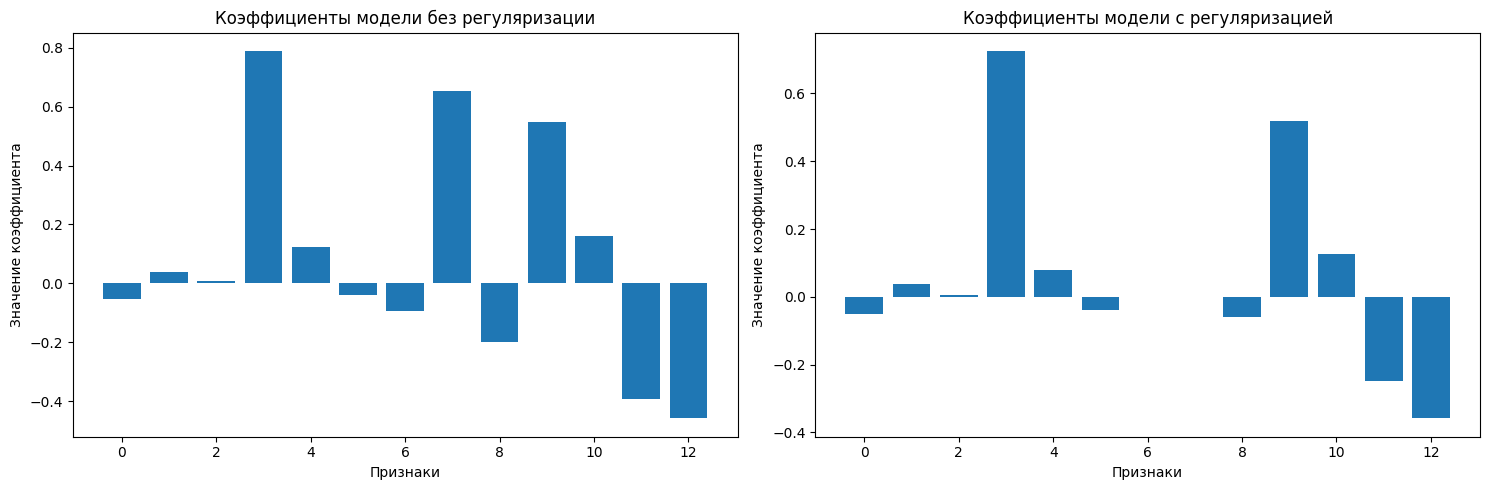

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [130]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7824
Точность на тестовой выборке: 0.7037

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33        16
           1       0.74      0.89      0.81        38

    accuracy                           0.70        54
   macro avg       0.62      0.57      0.57        54
weighted avg       0.67      0.70      0.67        54



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

Метод SequentialFeatureSelector — это инструмент для последовательного отбора признаков в наборе данных, используемый в машинном обучении для автоматизации процесса выбора наилучшего подмножества признаков. Он реализован в библиотеке sklearn в модуле sklearn.feature_selection и применяется для улучшения качества моделей и сокращения размерности данных. SequentialFeatureSelector итеративно добавляет или удаляет признаки, чтобы найти комбинацию признаков, которая максимизирует качество модели.

Основные характеристики SequentialFeatureSelector:
Пошаговый отбор признаков:

Метод последовательно включает или исключает признаки, оценивая качество модели на каждом шаге.
Процедура отбора может идти двумя путями:
Forward Selection (Прямой отбор): начинать с пустого множества признаков и последовательно добавлять те, которые улучшают метрику модели.
Backward Elimination (Обратное исключение): начинать с полного набора признаков и последовательно удалять те, которые наименее важны.

Коэффициенты модели без регуляризации: [[-0.0517851   0.03796209  0.00672944  0.7887012   0.1241958  -0.03889956
  -0.09412762  0.65178908 -0.19917148  0.54716832  0.16193292 -0.39119673
  -0.45762994]]
Коэффициенты модели с регуляризацией: [[-0.05093926  0.03767849  0.00647905  0.72551487  0.07992493 -0.03873384
   0.          0.         -0.05834605  0.51775625  0.12552182 -0.2467315
  -0.35826802]]
Отобранные признаки: Index(['resting blood pressure', 'serum cholestoral in mg/dl      ',
       'maximum heart rate achieved  ', 'number of major vessels ', 'thal'],
      dtype='object')
Коэффициенты модели после отбора признаков: [[ 0.03770517  0.00630168 -0.03887723  0.49957037  0.04834237]]


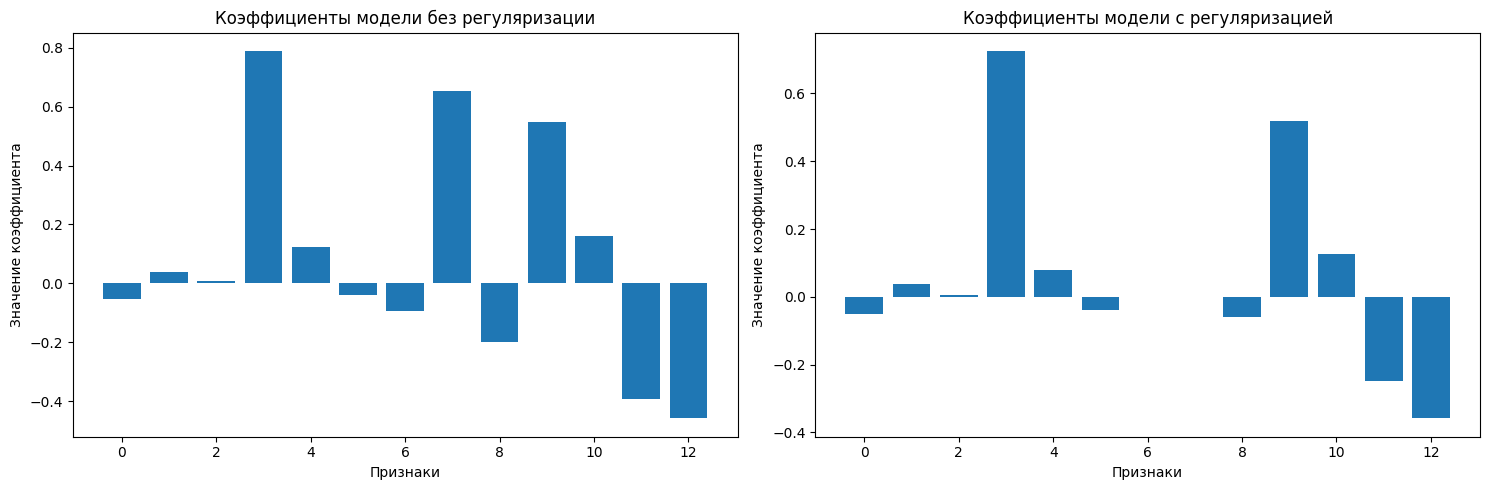

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty1 = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty1.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty1.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SequentialFeatureSelector(model_with_penalty, n_features_to_select =5, direction='forward', scoring='accuracy')
selector.fit(X_processed, Y)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [167]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)

Точность на обучающей выборке: 0.7824
Точность на тестовой выборке: 0.7407

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        16
           1       0.79      0.87      0.82        38

    accuracy                           0.74        54
   macro avg       0.68      0.65      0.66        54
weighted avg       0.73      0.74      0.73        54



## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [132]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [133]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [135]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [150]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K-Fold Cross-Validation - Средняя точность: 0.7555555555555555
Точности по каждому фолду: [0.6666666666666666, 0.7333333333333333, 0.6666666666666666, 0.8222222222222222, 0.8888888888888888, 0.7555555555555555]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Средняя точность по всем разбиениям: 0.7592592592592593
Точности по каждому фолду: [0.7037037037037037, 0.7777777777777778, 0.7037037037037037, 0.8148148148148148, 0.7962962962962963] между значениями по каждому разбиению есть весомая разница, это означает,что модель работает на всех разбиениях нестабильно. параметр n_splits=5, значит, что данные будут разбиты на 5 частей переменных, при пятерке точность самая максимальная, если брать значения выше или ниже точность ухуджается, так еще и при 5< числах дольше код выполняется

In [157]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=3, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.7098765432098766
Точности по каждому разделению: [0.6851851851851852, 0.7314814814814815, 0.7129629629629629]


Средняя точность по всем разбиениям в этом методе ухудшилась: 0.7425925925925926
Точности по каждому фолду: [0.7222222222222222, 0.7592592592592593, 0.75, 0.7592592592592593, 0.7222222222222222] между значениями по каждому разбиению небольшая, это означает,что модель работает на всех разбиениях стабильно. если увеличить параметр параметр n_splits=5, увеличится точность и скорость выполнения, если уменьшить, то уменьшится

### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [161]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.6851851851851852
Точность на тестовых данных: 0.7954545454545454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Точность на валидационных данных: 0.725925925925926
Точность на тестовых данных: 0.9259259259259259 если увеличить параметр
test_size=0.5, увеличится точность, на скорости выполнения почти не отражается

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

методы ShuffleSplit Cross-Validation, Train-Test-Validation Split  показали самую высокую точность на данных, но Train-Test-Validation Split был побыстрее



